In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2020-12-22 04:40:45--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   525KB/s    in 2m 47s  

2020-12-22 04:43:32 (1.43 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
!tar -zxf maps.tar.gz

In [ ]:
!ls

gdrive	maps  maps.tar.gz  sample_data


In [ ]:
import glob
train_files = glob.glob('maps/train/*.jpg')
test_files = glob.glob('maps/val/*.jpg')

In [ ]:
len(train_files), len(test_files)

(1096, 1098)

In [ ]:
import cv2
for file in train_files[:10]:
    map = cv2.imread(file)
    print (map.shape)

(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)


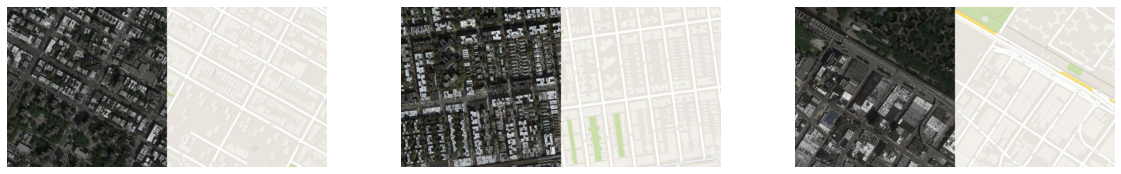

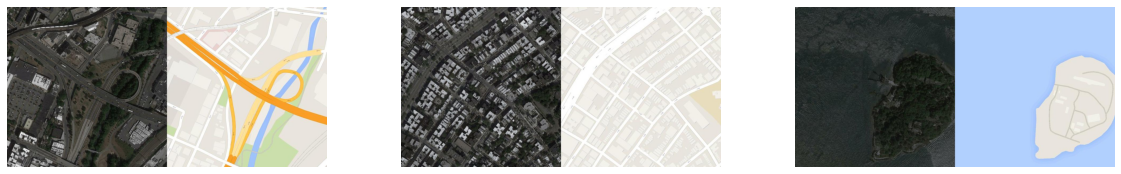

In [ ]:
for k in range(3):
    plt.figure(figsize=(20, 10))
    for j in range(3):
        file = np.random.choice(train_files)
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        plt.subplot(330 + 1 + j)
        plt.imshow(map)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

Input Images


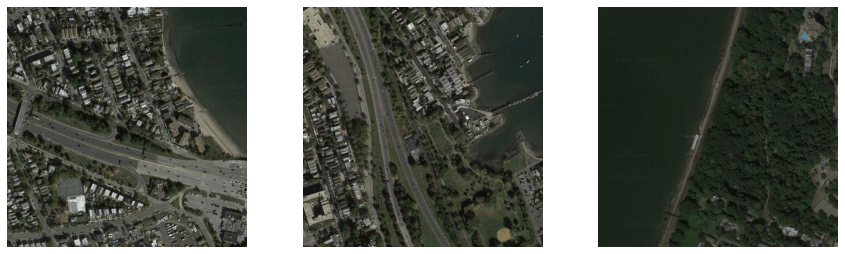

Output Images


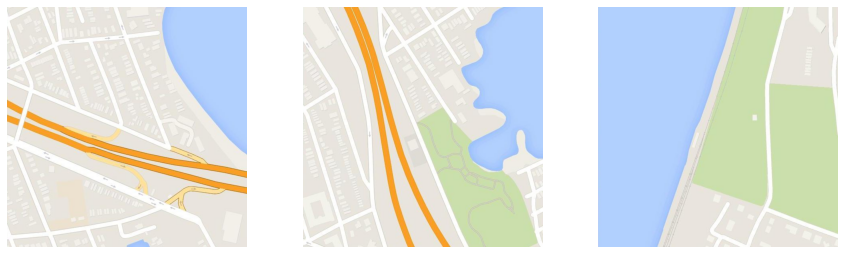

In [ ]:
maps = []
for j in range(3):
    file = np.random.choice(train_files)
    map = cv2.imread(file)
    map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
    maps.append(map)

print ('Input Images')
plt.figure(figsize=(15, 15))
for j, map in enumerate(maps):
    map1 = map[:, :map.shape[1]//2]
    plt.subplot(330 + 1 + j)
    plt.imshow(map1)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

print ('Output Images')
plt.figure(figsize=(15, 15))
for j, map in enumerate(maps):
    map2 = map[:, map.shape[1]//2:]
    plt.subplot(330 + 1 + j)
    plt.imshow(map2)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

# Generator Model (U-Net Like)

In [ ]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [ ]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

e1 = encoder_layer(source_image_input, 64, bn=False)#64
e2 = encoder_layer(e1, 64)#128
e3 = encoder_layer(e2, 64)#256
e4 = encoder_layer(e3, 128)#512
e5 = encoder_layer(e4, 128)#512
e6 = encoder_layer(e5, 128)#512
e7 = encoder_layer(e6, 128)#512

bottle_neck = tensorflow.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same')(e7)
b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

d1 = decoder_layer(b, e7, 128)#512
d2 = decoder_layer(d1, e6, 128)#512
d3 = decoder_layer(d2, e5, 128)#512
d4 = decoder_layer(d3, e4, 128)#512
d5 = decoder_layer(d4, e3, 64)#256
d6 = decoder_layer(d5, e2, 64)#128
d7 = decoder_layer(d6, e1, 64)#64

decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)

generator_network = tensorflow.keras.models.Model(inputs=source_image_input, outputs=translated_image)
print (generator_network.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   65600       leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

# Discriminator Network

In [ ]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [ ]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))
target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

combined = tensorflow.keras.layers.Concatenate(axis=-1)([source_image_input, target_image_input])

x = my_conv_layer(combined, 64, bn=False)#64
x = my_conv_layer(x, 64)#128
x = my_conv_layer(x, 128)#256
x = my_conv_layer(x, 256)#512

patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[source_image_input, target_image_input], outputs=patch_features)
print (discriminator_network.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_14[0][0]       

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# pix2pix

In [ ]:
discriminator_network.trainable=False

g_output = generator_network(source_image_input)
d_output = discriminator_network([source_image_input, g_output])

pix2pix = tensorflow.keras.models.Model(inputs=source_image_input, outputs=[d_output, g_output])
pix2pix.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  3686147     input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 16, 16, 1)    733441      input_3[0][0]                    
                                                                 model_1[0][0]                    
Total params: 4,419,588
Trainable params: 3,683,459
Non-trainable params: 736,129
__________________________________________________________________________________________________


# Compiling Models

In [ ]:
pix2pix.compile(loss=['mse', 'mae'], optimizer=adam_optimizer, loss_weights=[1, 100])

# Define Data Generators

In [ ]:
def get_predictions(input_sample, generator_network):
    input_sample = np.expand_dims(input_sample, axis=0)
    output_sample = generator_network.predict_on_batch(input_sample)
    return output_sample

def get_generated_samples(generator_network, maps_input):
    generated_samples = generator_network.predict_on_batch(maps_input)
    return generated_samples

def get_map_samples(batch_size):
    random_files = np.random.choice(train_files, size=batch_size)
    maps_input = []
    maps_output = []
    for file in random_files:
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        map1 = map[:, :map.shape[1]//2]
        map2 = map[:, map.shape[1]//2:]
        map1 = cv2.resize(map1, (256, 256))
        map2 = cv2.resize(map2, (256, 256))
        maps_input.append((map1-127.5)/127.5)
        maps_output.append((map2-127.5)/127.5)
    maps_input = np.array(maps_input)
    maps_output = np.array(maps_output)
    return maps_input, maps_output

def show_generator_results(generator_network):
    maps = []
    for j in range(3):
        file = np.random.choice(test_files)
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        maps.append(map)

    print ('Input Images')
    plt.figure(figsize=(15, 15))
    for j, map in enumerate(maps):
        map1 = map[:, :map.shape[1]//2]
        map1 = cv2.resize(map1, (256, 256))
        plt.subplot(330 + 1 + j)
        plt.imshow(map1)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Predicted Output Images')
    plt.figure(figsize=(15, 15))
    for j, map in enumerate(maps):
        map1 = map[:, :map.shape[1]//2]
        map1 = cv2.resize(map1, (256, 256))
        map1 = (map1-127.5)/127.5
        output = get_predictions(map1, generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(330 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Real Output Images')
    plt.figure(figsize=(15, 15))
    for j, map in enumerate(maps):
        map2 = map[:, map.shape[1]//2:]
        map2 = cv2.resize(map2, (256, 256))
        plt.subplot(330 + 1 + j)
        plt.imshow(map2)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [ ]:
len(train_files)

1096

Input Images


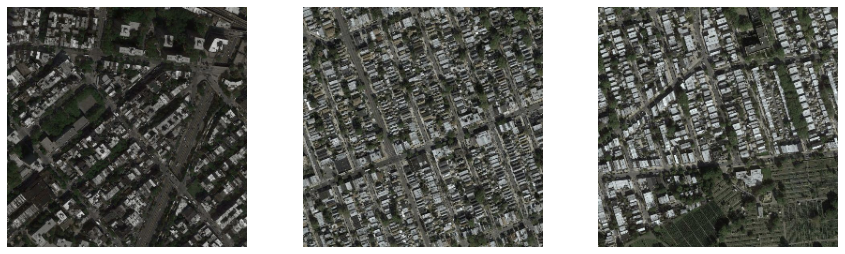

Predicted Output Images


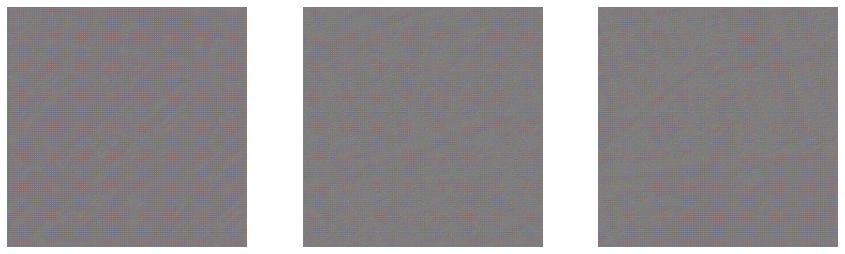

Real Output Images


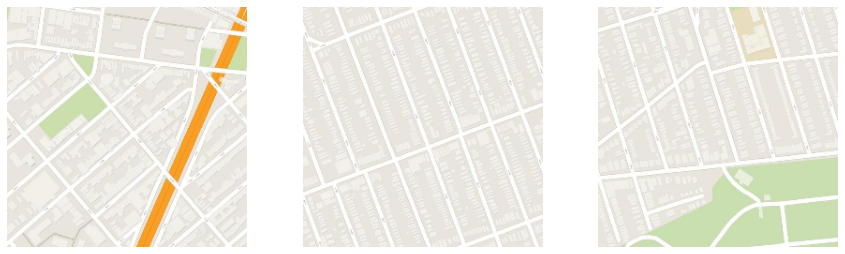

Epoch:0, Step:0, D-Loss:2.865, D-Acc:46.180, G-Loss:79.599
Epoch:0, Step:5, D-Loss:0.852, D-Acc:53.828, G-Loss:69.973
Epoch:0, Step:10, D-Loss:0.565, D-Acc:56.918, G-Loss:54.633
Epoch:1, Step:0, D-Loss:0.532, D-Acc:59.148, G-Loss:53.017
Epoch:1, Step:5, D-Loss:0.869, D-Acc:58.996, G-Loss:43.307
Epoch:1, Step:10, D-Loss:0.762, D-Acc:56.430, G-Loss:30.323
Epoch:2, Step:0, D-Loss:0.532, D-Acc:57.695, G-Loss:28.308
Epoch:2, Step:5, D-Loss:0.278, D-Acc:62.328, G-Loss:23.604
Epoch:2, Step:10, D-Loss:0.285, D-Acc:59.949, G-Loss:18.936
Epoch:3, Step:0, D-Loss:0.250, D-Acc:67.055, G-Loss:19.570
Epoch:3, Step:5, D-Loss:0.295, D-Acc:55.582, G-Loss:16.180
Epoch:3, Step:10, D-Loss:0.251, D-Acc:64.477, G-Loss:16.444
Epoch:4, Step:0, D-Loss:0.201, D-Acc:71.574, G-Loss:14.585
Epoch:4, Step:5, D-Loss:0.187, D-Acc:76.719, G-Loss:13.748
Epoch:4, Step:10, D-Loss:0.191, D-Acc:74.023, G-Loss:13.170
Epoch:5, Step:0, D-Loss:0.164, D-Acc:78.258, G-Loss:13.009
Epoch:5, Step:5, D-Loss:0.187, D-Acc:75.559, G-Loss

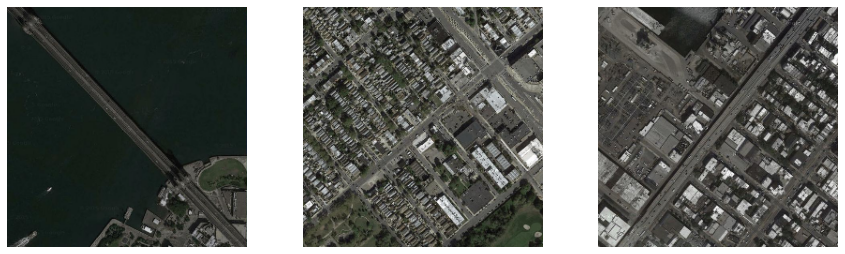

Predicted Output Images


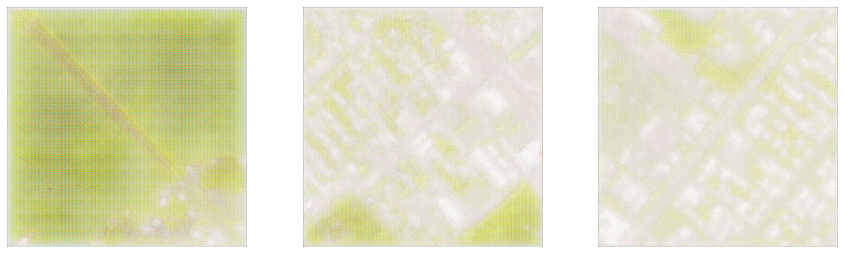

Real Output Images


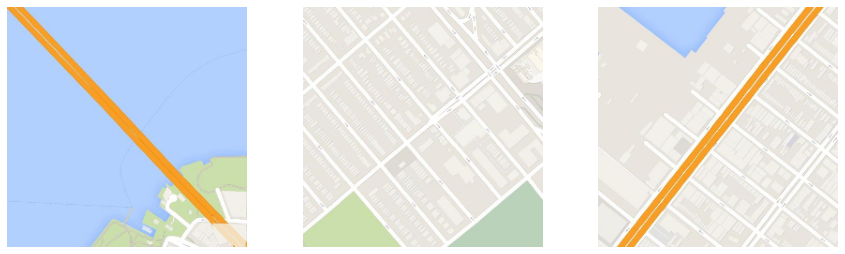

Epoch:10, Step:0, D-Loss:0.069, D-Acc:96.418, G-Loss:11.015
Epoch:10, Step:5, D-Loss:0.162, D-Acc:84.289, G-Loss:10.223
Epoch:10, Step:10, D-Loss:0.098, D-Acc:90.488, G-Loss:9.237
Epoch:11, Step:0, D-Loss:0.073, D-Acc:94.906, G-Loss:10.003
Epoch:11, Step:5, D-Loss:0.321, D-Acc:84.930, G-Loss:11.065
Epoch:11, Step:10, D-Loss:0.307, D-Acc:63.609, G-Loss:11.022
Epoch:12, Step:0, D-Loss:0.286, D-Acc:79.723, G-Loss:10.762
Epoch:12, Step:5, D-Loss:0.237, D-Acc:67.082, G-Loss:10.465
Epoch:12, Step:10, D-Loss:0.106, D-Acc:89.457, G-Loss:9.694
Epoch:13, Step:0, D-Loss:0.371, D-Acc:48.133, G-Loss:9.694
Epoch:13, Step:5, D-Loss:0.103, D-Acc:88.883, G-Loss:10.147
Epoch:13, Step:10, D-Loss:0.077, D-Acc:94.715, G-Loss:9.429
Epoch:14, Step:0, D-Loss:0.086, D-Acc:93.578, G-Loss:9.464
Epoch:14, Step:5, D-Loss:0.400, D-Acc:49.949, G-Loss:9.819
Epoch:14, Step:10, D-Loss:0.102, D-Acc:88.781, G-Loss:9.690
Epoch:15, Step:0, D-Loss:0.298, D-Acc:50.742, G-Loss:9.478
Epoch:15, Step:5, D-Loss:0.092, D-Acc:91.14

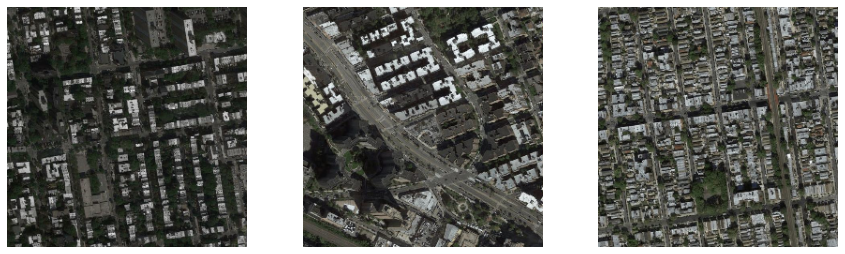

Predicted Output Images


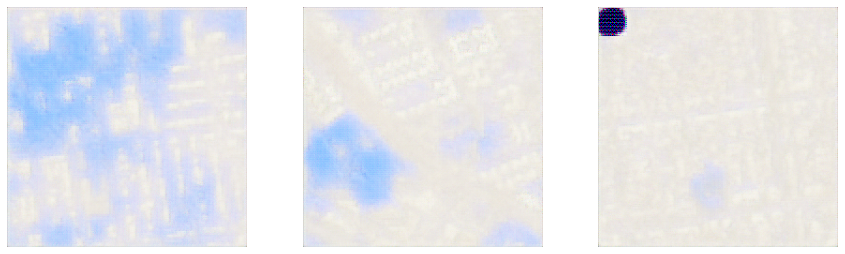

Real Output Images


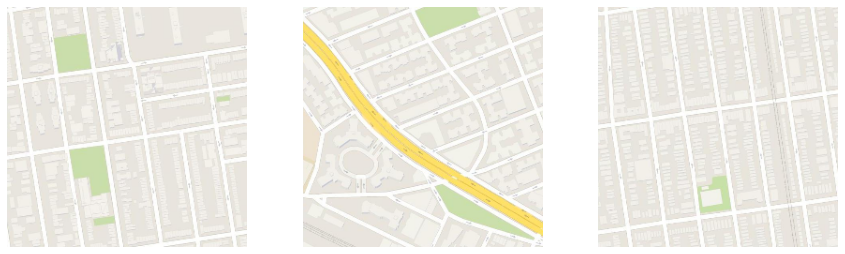

Epoch:20, Step:0, D-Loss:0.104, D-Acc:90.848, G-Loss:9.718
Epoch:20, Step:5, D-Loss:0.024, D-Acc:99.469, G-Loss:10.892
Epoch:20, Step:10, D-Loss:0.021, D-Acc:99.863, G-Loss:9.533
Epoch:21, Step:0, D-Loss:0.021, D-Acc:99.977, G-Loss:10.674
Epoch:21, Step:5, D-Loss:0.023, D-Acc:99.977, G-Loss:10.069
Epoch:21, Step:10, D-Loss:0.023, D-Acc:99.441, G-Loss:11.024
Epoch:22, Step:0, D-Loss:0.017, D-Acc:99.961, G-Loss:9.614
Epoch:22, Step:5, D-Loss:0.017, D-Acc:99.680, G-Loss:9.494
Epoch:22, Step:10, D-Loss:0.015, D-Acc:100.000, G-Loss:9.626
Epoch:23, Step:0, D-Loss:0.017, D-Acc:99.820, G-Loss:9.097
Epoch:23, Step:5, D-Loss:0.029, D-Acc:99.602, G-Loss:8.952
Epoch:23, Step:10, D-Loss:0.018, D-Acc:99.742, G-Loss:10.408
Epoch:24, Step:0, D-Loss:0.024, D-Acc:99.949, G-Loss:8.831
Epoch:24, Step:5, D-Loss:0.017, D-Acc:99.965, G-Loss:9.247
Epoch:24, Step:10, D-Loss:0.016, D-Acc:99.937, G-Loss:9.088
Epoch:25, Step:0, D-Loss:0.022, D-Acc:99.957, G-Loss:9.182
Epoch:25, Step:5, D-Loss:0.017, D-Acc:100.000

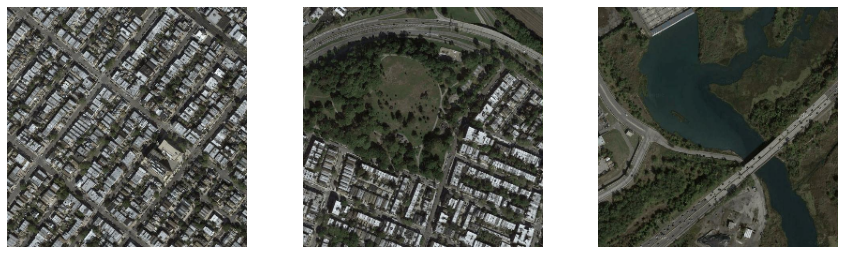

Predicted Output Images


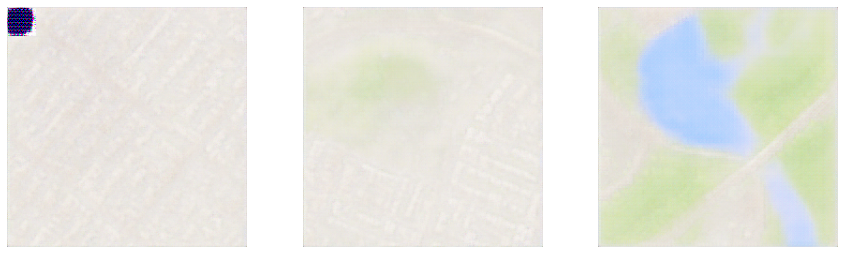

Real Output Images


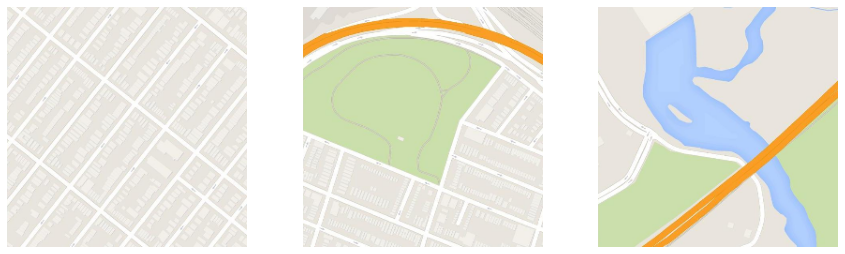

Epoch:30, Step:0, D-Loss:0.031, D-Acc:98.582, G-Loss:8.905
Epoch:30, Step:5, D-Loss:0.032, D-Acc:99.945, G-Loss:9.396
Epoch:30, Step:10, D-Loss:0.017, D-Acc:99.707, G-Loss:8.646
Epoch:31, Step:0, D-Loss:0.010, D-Acc:99.953, G-Loss:9.581
Epoch:31, Step:5, D-Loss:0.007, D-Acc:99.992, G-Loss:8.480
Epoch:31, Step:10, D-Loss:0.015, D-Acc:99.852, G-Loss:9.378
Epoch:32, Step:0, D-Loss:0.011, D-Acc:100.000, G-Loss:8.489
Epoch:32, Step:5, D-Loss:0.017, D-Acc:99.824, G-Loss:9.126
Epoch:32, Step:10, D-Loss:0.009, D-Acc:99.977, G-Loss:9.003
Epoch:33, Step:0, D-Loss:0.019, D-Acc:100.000, G-Loss:10.663
Epoch:33, Step:5, D-Loss:0.028, D-Acc:98.906, G-Loss:9.129
Epoch:33, Step:10, D-Loss:0.011, D-Acc:99.887, G-Loss:10.564
Epoch:34, Step:0, D-Loss:0.016, D-Acc:99.793, G-Loss:8.758
Epoch:34, Step:5, D-Loss:0.008, D-Acc:99.996, G-Loss:9.523
Epoch:34, Step:10, D-Loss:0.382, D-Acc:60.203, G-Loss:9.676
Epoch:35, Step:0, D-Loss:0.446, D-Acc:50.797, G-Loss:9.635
Epoch:35, Step:5, D-Loss:0.034, D-Acc:99.719, G

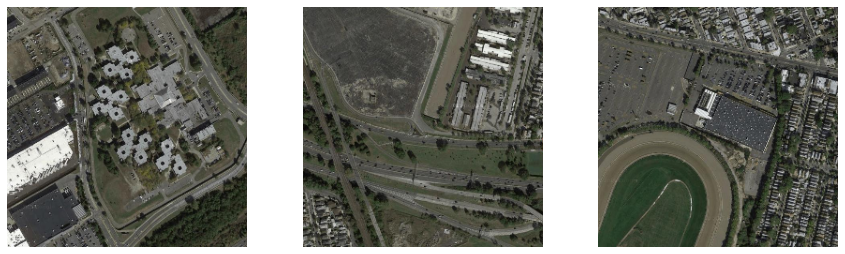

Predicted Output Images


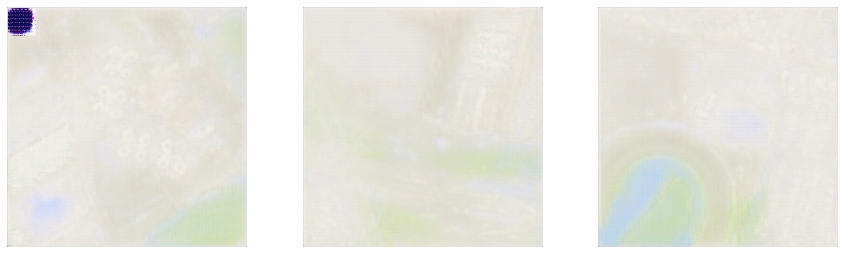

Real Output Images


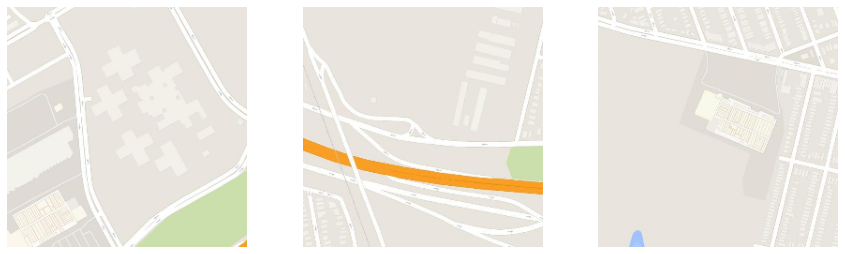

Epoch:40, Step:0, D-Loss:0.040, D-Acc:97.770, G-Loss:8.584
Epoch:40, Step:5, D-Loss:0.023, D-Acc:99.973, G-Loss:9.055
Epoch:40, Step:10, D-Loss:0.015, D-Acc:100.000, G-Loss:9.026
Epoch:41, Step:0, D-Loss:0.010, D-Acc:100.000, G-Loss:8.267
Epoch:41, Step:5, D-Loss:0.126, D-Acc:84.977, G-Loss:8.918
Epoch:41, Step:10, D-Loss:0.016, D-Acc:99.922, G-Loss:8.496
Epoch:42, Step:0, D-Loss:0.022, D-Acc:99.992, G-Loss:8.168
Epoch:42, Step:5, D-Loss:0.016, D-Acc:99.754, G-Loss:8.316
Epoch:42, Step:10, D-Loss:0.460, D-Acc:50.000, G-Loss:8.863
Epoch:43, Step:0, D-Loss:0.024, D-Acc:99.758, G-Loss:9.007
Epoch:43, Step:5, D-Loss:0.015, D-Acc:99.996, G-Loss:8.859
Epoch:43, Step:10, D-Loss:0.013, D-Acc:99.863, G-Loss:7.877
Epoch:44, Step:0, D-Loss:0.012, D-Acc:100.000, G-Loss:8.613
Epoch:44, Step:5, D-Loss:0.008, D-Acc:99.965, G-Loss:9.549
Epoch:44, Step:10, D-Loss:0.012, D-Acc:99.980, G-Loss:8.267
Epoch:45, Step:0, D-Loss:0.035, D-Acc:99.215, G-Loss:8.913
Epoch:45, Step:5, D-Loss:0.021, D-Acc:99.379, G-

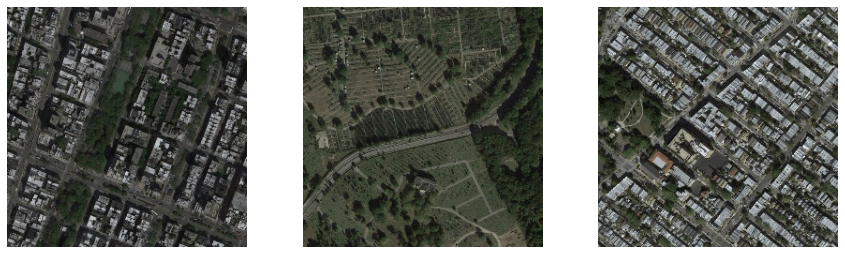

Predicted Output Images


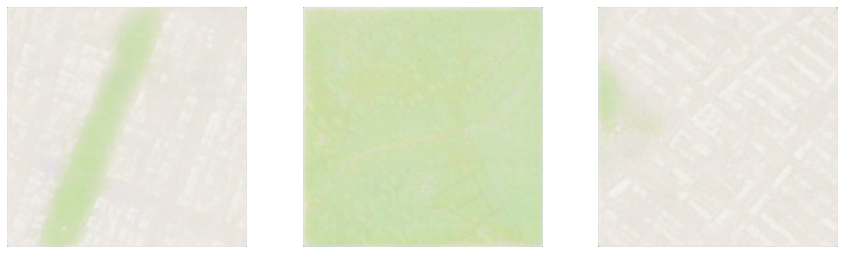

Real Output Images


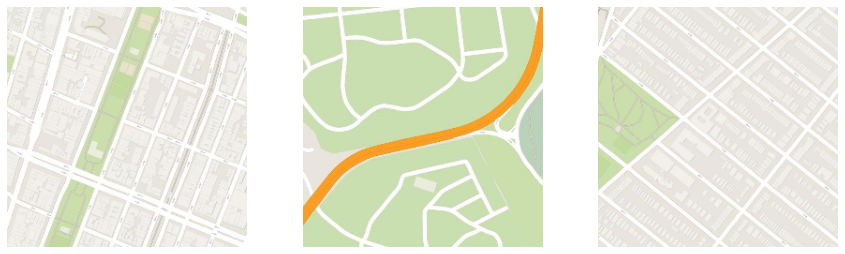

Epoch:50, Step:0, D-Loss:0.007, D-Acc:100.000, G-Loss:8.663
Epoch:50, Step:5, D-Loss:0.041, D-Acc:99.898, G-Loss:8.809
Epoch:50, Step:10, D-Loss:0.010, D-Acc:99.996, G-Loss:8.060
Epoch:51, Step:0, D-Loss:0.010, D-Acc:99.996, G-Loss:7.980
Epoch:51, Step:5, D-Loss:0.025, D-Acc:99.687, G-Loss:8.112
Epoch:51, Step:10, D-Loss:0.041, D-Acc:97.828, G-Loss:8.324
Epoch:52, Step:0, D-Loss:0.031, D-Acc:99.996, G-Loss:9.347


In [ ]:
epochs = 500
batch_size = 100
steps = 11

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
    for j in range(steps):
        maps_input, maps_output = get_map_samples(batch_size=batch_size//2)
        generated_maps_output = get_generated_samples(generator_network, maps_input)

        fake_patch = np.zeros((batch_size//2, 16, 16, 1))
        real_patch = np.ones((batch_size//2, 16, 16, 1))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d1 = discriminator_network.train_on_batch([maps_input, maps_output], real_patch)
        loss_d2 = discriminator_network.train_on_batch([maps_input, generated_maps_output], fake_patch)
        
        loss_d = (np.add(loss_d1, loss_d2))/2.0
        
        
        maps_input, maps_output = get_map_samples(batch_size=batch_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g, _, _ = pix2pix.train_on_batch(maps_input, [real_patch, maps_output])
        
        if j%10 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))   